# **Analizando un grupo de WhatsApp**

## 1 Introducción

En esta notebook se explorar el comportamiento de un grupo de WhatsApp a lo largo del tiempo. Empezaremos limpiando y organizando los datos, creando un DataFrame con información sobre **fecha y hora de los mensajes**, **quién los envió** (anonimizado) y **su contenido**.

Después realizaremos un **análisis exploratorio**, respondiendo preguntas como:

* ¿Quiénes son los miembros más activos del grupo?
* ¿Cuándo se envían más mensajes a lo largo del día y de la semana?
* ¿Cómo cambia la actividad a lo largo del semestre o del año?
* ¿Qué palabras se usan más y qué nos dicen sobre el tipo de conversación del grupo?

Finalmente, haremos algunos **análisis adicionales** para entender patrones interesantes, como quién manda mensajes más largos o más cortos, y cómo varía la participación entre los miembros.


### 1.1 Configuraciones de entorno

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

import re
import zipfile
from pathlib import Path

In [162]:
plt.style.use('ggplot')

Los directorios de datos: 

In [163]:
BASE = Path().resolve().parent
DATA = BASE / "data"
RAW = DATA / "raw"
PROCESSED = DATA / "processed"

In [164]:
BASE.exists(), BASE.is_dir()

(True, True)

Aseguramos que los directorios están presentes en el proyecto: 

In [165]:
RAW.mkdir(exist_ok=True, parents=True)
PROCESSED.mkdir(exist_ok=True, parents=True)

## 2 Ingesta de Datos

Los datos han sido descargados directamente desde un gurpo de WhatsApp y colocados en `data/raw` con el nombre de `grupo.zip`. 

Verifiquemos que los datos están presentes: 

In [166]:
for item in RAW.iterdir():
    if item.suffix == '.zip': 
        print(item.relative_to(BASE))

data\raw\grupo.zip


Creamos el apuntador al archivo y verificamos que existe y que es un archivo válido: 

In [167]:
zfile = RAW / "grupo.zip"

zfile.exists(), zfile.is_file()

(True, True)

El archivo de salida: 

In [168]:
outpath = RAW / "grupo.txt"

Para extraer el archivo `ZIP` usamos el paquete `zipfile`: 

In [169]:
with zipfile.ZipFile(zfile, 'r') as file:
    filename = file.namelist()[0]

    with file.open(filename) as source: 
        with open(outpath, 'wb') as target:
            target.write(source.read())

Verificamos que el archivo se ha extraido correctamente: 

In [170]:
outpath.exists(), outpath.is_file()

(True, True)

Una vez extraido podemos cambiamos de manera manual los nombres de los participantes. En total hay 6 participantes en el gurpo y se han usado nombres de los superheroes de la liga de la justicia: Batman, Aquaman, Superman, Wonder Woman y Hulk. EL archivo de texto con los nombres modificados está en la dirección `data/raw/grupo_no_names.txt`

Ahora, cargamos el archivo de texto y demos un vistazo a los datos: 

In [171]:
nonamespath = RAW / "grupo_no_names.txt"
nonamespath.exists(), nonamespath.is_file()

(True, True)

In [172]:
with open(nonamespath, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i == 10:  # las primeras 20 lineas
            break

10/4/2023, 11:39 - Los mensajes y las llamadas están cifrados de extremo a extremo. Solo las personas en este chat pueden leerlos, escucharlos o compartirlos. Obtén más información.
10/4/2023, 11:39 - ‎Wonder Woman creó el grupo "grupo".
10/4/2023, 11:39 - ‎Wonder Woman te añadió
10/4/2023, 11:40 - Flash: ✋✋✋
10/4/2023, 11:41 - Flash: Rola las fotos Wonder Woman
10/4/2023, 11:41 - Flash: Un parienton
10/4/2023, 11:43 - Wonder Woman: ayuda el Batman está hablando ***
10/4/2023, 11:45 - Batman: Hao✋
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>
10/4/2023, 11:55 - Flash: <Multimedia omitido>


Obtenemos una lista con las lineas del texto: 

In [173]:
with open(nonamespath, 'r', encoding="utf-8") as f:
    lines = f.readlines()

In [174]:
len(lines), lines[:5]

(11317,
 ['10/4/2023, 11:39 - Los mensajes y las llamadas están cifrados de extremo a extremo. Solo las personas en este chat pueden leerlos, escucharlos o compartirlos. Obtén más información.\n',
  '10/4/2023, 11:39 - \u200eWonder Woman creó el grupo "grupo".\n',
  '10/4/2023, 11:39 - \u200eWonder Woman te añadió\n',
  '10/4/2023, 11:40 - Flash: ✋✋✋\n',
  '10/4/2023, 11:41 - Flash: Rola las fotos Wonder Woman\n'])

Ahora, separamos cada línea como una tupla con los campos `fecha`, `hora`, `usuario`, `mensaje`. 

Para ello, primero conviene analizar la estructura de las líneas: 

Podemos englobar todo lo anterior con la siguiente función:

In [175]:
def get_fields(lines):
    # Regex para mensajes normales (con usuario)
    msg_pattern = r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*?): (.*)'
    # Regex para mensajes de sistema (sin usuario)
    sys_pattern = r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*)'

    tuples = []
    
    for line in lines:
        line = line.strip()
        msg_match = re.match(msg_pattern, line)
        sys_match = re.match(sys_pattern, line)

        if msg_match:
            # Nuevo mensaje con usuario
            fecha, hora, nombre, contenido = msg_match.groups()
            tuples.append((fecha, hora, nombre, contenido))
        
        elif sys_match:
            # Mensaje del sistema
            fecha, hora, contenido = sys_match.groups()
            tuples.append((fecha, hora, "<Sistema>", contenido))
        
        else:
            # Continuación de mensaje anterior
            if tuples:
                fecha, hora, nombre, contenido = tuples[-1]
                contenido = contenido + " " + line  # concatenamos
                tuples[-1] = (fecha, hora, nombre, contenido)
            else:
                # Caso raro: primera línea sin fecha
                tuples.append((None, None, "<Desconocido>", line))
    
    return tuples


In [176]:
tuple_msgs = get_fields(lines)

len(tuple_msgs), tuple_msgs[:5]

(10769,
 [('10/4/2023',
   '11:39',
   '<Sistema>',
   'Los mensajes y las llamadas están cifrados de extremo a extremo. Solo las personas en este chat pueden leerlos, escucharlos o compartirlos. Obtén más información.'),
  ('10/4/2023',
   '11:39',
   '<Sistema>',
   '\u200eWonder Woman creó el grupo "grupo".'),
  ('10/4/2023', '11:39', '<Sistema>', '\u200eWonder Woman te añadió'),
  ('10/4/2023', '11:40', 'Flash', '✋✋✋'),
  ('10/4/2023', '11:41', 'Flash', 'Rola las fotos Wonder Woman')])

Ahora, pasamos los datos de texto a `DataFrame`: 

In [177]:
df = pd.DataFrame(tuple_msgs, columns=['fecha', 'hora', 'usuario', 'mensaje'])

## 3 Limpieza y Procesamiento

Una pequeña exploración a los mensajes en forma de `DataFrame`: 

In [178]:
df.head()

,fecha,hora,usuario,mensaje
0,10/4/2023,11:39,<Sistema>,Los mensajes y las llamadas están cifrados de ...
1,10/4/2023,11:39,<Sistema>,"‎Wonder Woman creó el grupo ""grupo""."
2,10/4/2023,11:39,<Sistema>,‎Wonder Woman te añadió
3,10/4/2023,11:40,Flash,✋✋✋
4,10/4/2023,11:41,Flash,Rola las fotos Wonder Woman


In [179]:
df.dtypes

fecha      object
hora       object
usuario    object
mensaje    object
dtype: object

Es necesario unir la fecha y hora una sola columna `datetime`:

In [180]:
df['datetime'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'], format="%d/%m/%Y %H:%M")
df['datetime'].head()

0   2023-04-10 11:39:00
1   2023-04-10 11:39:00
2   2023-04-10 11:39:00
3   2023-04-10 11:40:00
4   2023-04-10 11:41:00
Name: datetime, dtype: datetime64[ns]

Eliminamos las columnas `fecha` y `hora`: 

In [181]:
df.drop(columns=['fecha', 'hora'], inplace=True)

Ahora, analicemos la columna `mensaje` para determinar el tipo de mensaje: 

In [182]:
df['mensaje'].head()

0    Los mensajes y las llamadas están cifrados de ...
1                 ‎Wonder Woman creó el grupo "grupo".
2                              ‎Wonder Woman te añadió
3                                                  ✋✋✋
4                          Rola las fotos Wonder Woman
Name: mensaje, dtype: object

Conviene normalizar las cadenas de mensaje: 

In [183]:
df['mensaje'] = df['mensaje'].str.lower()

Vemos que los elementos multimedia (stickers, videos, etc.) se identifican con la palabra `<multimedia omitido>`: 

In [184]:
multimedias = df[df['mensaje'].str.contains('multimedia')]
multimedias['mensaje'].unique()

array(['<multimedia omitido>'], dtype=object)

Debido a que se han exportado los mensajes considerando únicamente los mensajes, no es posible saber si el mensaje multimedia es un audio, video, imagen, documento ó sticker. Por lo que las categorias serán unicamente `texto` y multimedia: 

In [185]:
def classify_msg(line): 
    if 'multimedia' in line:
        return 'multimedia'
    else: 
        return 'texto'

In [186]:
df['tipo'] = df['mensaje'].apply(classify_msg)

In [187]:
df['tipo'].unique()

array(['texto', 'multimedia'], dtype=object)

Ahora, se crearé la columna `num_palabras` que posee la cantidad de palabras en el mensaje: 

In [188]:
df['mensaje'].head()

0    los mensajes y las llamadas están cifrados de ...
1                 ‎wonder woman creó el grupo "grupo".
2                              ‎wonder woman te añadió
3                                                  ✋✋✋
4                          rola las fotos wonder woman
Name: mensaje, dtype: object

In [189]:
df['num_palabras'] = df['mensaje'].str.split(' ').str.len()

In [190]:
df.head();   # OK

Por último, la columna `num_chars` que almacena la cantidad de carácteres de cada mensaje: 

In [191]:
df['num_chars'] = df['mensaje'].str.len()

In [192]:
df.head();  # OK

In [193]:
df.dtypes

usuario                 object
mensaje                 object
datetime        datetime64[ns]
tipo                    object
num_palabras             int64
num_chars                int64
dtype: object

¡La limpieza esta completa!

Reorganicemos las columnas del `DataFrame`: 

In [194]:
df = df[['datetime', 'usuario', 'mensaje', 'tipo', 'num_palabras', 'num_chars']]
df.head()

,datetime,usuario,mensaje,tipo,num_palabras,num_chars
0,2023-04-10 11:39:00,<Sistema>,los mensajes y las llamadas están cifrados de ...,texto,25,162
1,2023-04-10 11:39:00,<Sistema>,"‎wonder woman creó el grupo ""grupo"".",texto,6,36
2,2023-04-10 11:39:00,<Sistema>,‎wonder woman te añadió,texto,4,23
3,2023-04-10 11:40:00,Flash,✋✋✋,texto,1,3
4,2023-04-10 11:41:00,Flash,rola las fotos wonder woman,texto,5,27


Por último, guardamos el dataframe ya procesado para su posterior análisis: 

In [195]:
cleanpath = PROCESSED / "grupo_clean.csv"

In [196]:
df.to_csv(cleanpath)

## 4 Análisis Exploratorio de Datos

Primero cargamos el archivo ya limpio: 

In [197]:
df = pd.read_csv(cleanpath, index_col=0)

In [198]:
df.head()   # Ok

,datetime,usuario,mensaje,tipo,num_palabras,num_chars
0,2023-04-10 11:39:00,<Sistema>,los mensajes y las llamadas están cifrados de ...,texto,25,162
1,2023-04-10 11:39:00,<Sistema>,"‎wonder woman creó el grupo ""grupo"".",texto,6,36
2,2023-04-10 11:39:00,<Sistema>,‎wonder woman te añadió,texto,4,23
3,2023-04-10 11:40:00,Flash,✋✋✋,texto,1,3
4,2023-04-10 11:41:00,Flash,rola las fotos wonder woman,texto,5,27


Validamos los tipos de cada columna: 

In [199]:
df.dtypes

datetime        object
usuario         object
mensaje         object
tipo            object
num_palabras     int64
num_chars        int64
dtype: object

In [200]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [201]:
df.dtypes

datetime        datetime64[ns]
usuario                 object
mensaje                 object
tipo                    object
num_palabras             int64
num_chars                int64
dtype: object

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10769 entries, 0 to 10768
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10769 non-null  datetime64[ns]
 1   usuario       10769 non-null  object        
 2   mensaje       10769 non-null  object        
 3   tipo          10769 non-null  object        
 4   num_palabras  10769 non-null  int64         
 5   num_chars     10769 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 588.9+ KB


Observamos que hay 10769 registros y no hay ningún elemento nulo. 

Procedemos a hacer el análisis exploratorio de los datos. 

### 4.1 Estadísticas Descriptivas

Una descripción de las variables numércias: 

In [203]:
df.select_dtypes('int64').describe()

,num_palabras,num_chars
count,10769.000000,10769.000000
mean,4.162132,23.790603
std,5.212631,30.519491
min,1.000000,1.000000
25%,2.000000,11.000000
50%,3.000000,20.000000
75%,5.000000,28.000000
max,219.000000,1385.000000


* El promedio de palabras por mensaje es de 4 con una desviación estándar de 5.

* EL promedio de carácteres por mensaje es de 5 con una desviación estándar de 30. 

Los usuarios únicos: 

In [204]:
users = df['usuario'].unique().tolist()
users

['<Sistema>', 'Flash', 'Wonder Woman', 'Batman', 'Superman', 'Aquaman', 'Hulk']

* Sin contar al **<Sistema>** en el grupo hay 6 usuarios, todos con los nombres de los superheroes de la liga de la Justicia. 

* Recordemos que **<Sistema>** son aquellos mensajes relacionados cambios en el grupo: agregar/expulsar miembros, miembros que salen del grupo, cambios de foto del grupo, etc. 

Analicemos ahora el comportamiento de los mensajes por cada usuario: 

La fecha de inicio y la fecha final: 

In [205]:
fecha_inicio = df['datetime'].min()
fecha_final = df['datetime'].max()

In [206]:
print(f'El chat posee mensajes desde {fecha_inicio} hasta {fecha_final}')

El chat posee mensajes desde 2023-04-10 11:39:00 hasta 2024-10-26 18:47:00


### 4.2 Usuarios más activos

Para analizar la actividad de los usuarios consideremos el total de mensajes por miembro:  

In [207]:
count_mensajes = df['usuario'].value_counts().reset_index()
count_mensajes

,usuario,count
0,Wonder Woman,4140
1,Flash,1833
2,Superman,1785
3,Hulk,1286
4,Aquaman,1138
5,Batman,564
6,<Sistema>,23


Para obtener información más reprecentativa, obtengamos la relación entre la cantidad de mensajes y el total de mensajes en el grupo: 

In [208]:
total_mensajes = len(df)
total_mensajes

10769

In [209]:
count_mensajes[r'%'] = count_mensajes['count'] * 100 / total_mensajes 
count_mensajes

,usuario,count,%
0,Wonder Woman,4140,38.443681
1,Flash,1833,17.021079
2,Superman,1785,16.575355
3,Hulk,1286,11.941684
4,Aquaman,1138,10.567369
5,Batman,564,5.237255
6,<Sistema>,23,0.213576


**Wonder Woman**  fue el usuario que más habló y con mucha diferencia con el resto. Por otro lado,  **Batman** fue el miembro con más silencioso.


Un `countplot` del total de mensajes por miembros:

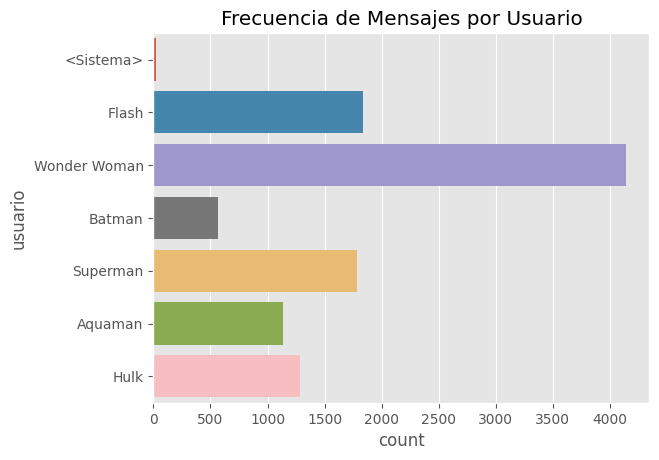

In [210]:
g = sns.countplot(
    data=df,
    y='usuario',
    hue='usuario', 
    # stat='percent'
)
g.set(
    title='Frecuencia de Mensajes por Usuario'
)
plt.show()

En base a los datos del grupo, podemos decir lo siguiente: 

* **Wonder Woman** domina claramente la conversación, con **4140 mensajes**, lo que representa un **38.44%** del total.
    + Es la más **activa** del grupo con diferencia.

* **Flash** y **Superman** le siguen con **1833** (17.02%) y **1785** (16.58%) mensajes, respectivamente.
    + Ambos tienen una participación considerable, aunque cada uno representa menos de la mitad de la actividad de Wonder Woman.

* Luego vienen **Hulk** y **Aquaman**, con una participación **intermedia**:
    + Hulk: 1286 mensajes (11.94%)
    + Aquaman: 1138 mensajes (10.57%)

* **Batman** es el más reservado entre los superhéroes, con solo **564 mensajes** (5.24%).
    + Podría ser considerado el más **callado** del grupo.

* **<Sistema>** apenas representa el 0.21% con 23 mensajes, lo cual es esperable, ya que probablemente se trate de mensajes automáticos del sistema (cambios de nombre, miembros añadidos/salidas, etc.).

### 4.3 Texto vs Multimedia

En el grupo identificaamos dos tipos de mensajes: multimedia y texto. 

Determinemos la cantidad de mensajes por tipo: 

In [211]:
df.groupby('tipo')['tipo'].agg('count')

tipo
multimedia    1446
texto         9323
Name: tipo, dtype: int64

La cantidd de mensajes de tipo multimedia es muy baja, reprecenta el 10-15% del total de mensajes en el grupo.

Ahora, observemos la distribución del tipo de mensaje por usuario: 

In [212]:
tabla = (
    df.groupby(['usuario', 'tipo'])['tipo']
      .agg('count')
      .unstack(fill_value=0)
      .reset_index()
)

In [213]:
tabla.columns.name = None
tabla

,usuario,multimedia,texto
0,<Sistema>,0,23
1,Aquaman,298,840
2,Batman,26,538
3,Flash,229,1604
4,Hulk,120,1166
5,Superman,339,1446
6,Wonder Woman,434,3706


In [214]:
tabla.columns

Index(['usuario', 'multimedia', 'texto'], dtype='object')

Para reprecentar la información como barras, es necesario convertir a *long-format*. Usamos `pd.melt` como sigue: 

In [215]:
long_tabla = tabla.melt(id_vars="usuario", 
                  value_vars=["multimedia", "texto"], 
                  var_name="tipo", value_name="cantidad")


In [216]:
long_tabla;  # OK

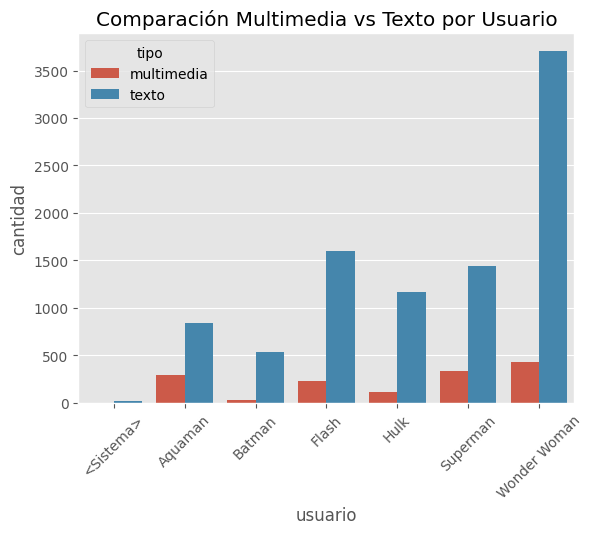

In [217]:
sns.barplot(
    data=long_tabla,
    x="usuario",
    y="cantidad", 
    hue="tipo"
)
plt.xticks(rotation=45)
plt.title("Comparación Multimedia vs Texto por Usuario")
plt.show()


Observamos que Aquaman, Wonder Woman y Superman enviaron una cantidad similar de archivos multimedia.

### 4.3 Ditribución temporal

Para analizar la distribución temporal de los mensajes, es necesario extraer otras variables interesantes de la columna `datetime`, en particular la hora del mensaje y el día de la semana: 

In [218]:
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name(locale='es_ES')

In [219]:
df.head();  # OK

Los mensajes por hora del día: 

In [220]:
hourly_counts = df.groupby('hour').size()

Observemos la distribución por hora mediante un gráfico de barras:

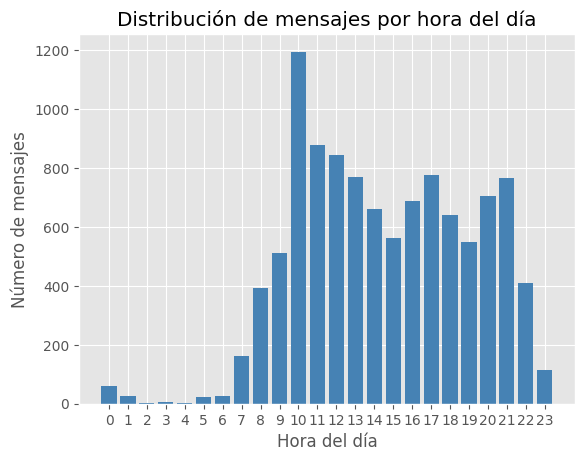

In [221]:
plt.bar(hourly_counts.index, hourly_counts.values, color="steelblue")
plt.xticks(range(0,24))
plt.xlabel("Hora del día")
plt.ylabel("Número de mensajes")
plt.title("Distribución de mensajes por hora del día")
plt.show()

La mayor parte de los mensajes ocurren entre las 9 y 12. 

Ahora, contemos los mensajes por día de la semana: 

In [222]:
weekday_counts = df['day_of_week'].value_counts()

Ordenamos naturalmente los días de la semana: 

In [223]:
orden = ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]
weekday_counts = weekday_counts.reindex(orden)

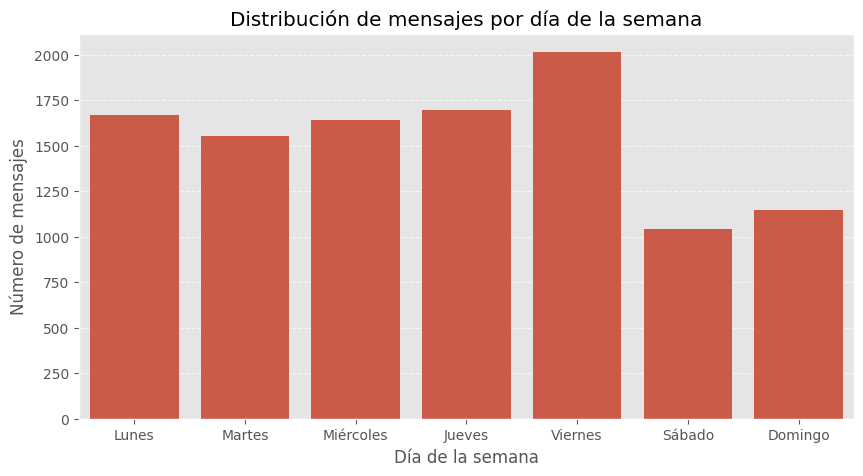

In [224]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=weekday_counts
)
plt.xlabel("Día de la semana")
plt.ylabel("Número de mensajes")
plt.title("Distribución de mensajes por día de la semana")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La distribución es bastante uniforme, con 1500-1700 mensajes en promedio entre semana y aproximadamente 1000 mensajes en total los fines de semana. 

Nótese que el pico se presenta el día veirnes. Con poco más de 2000 mensajes en total. 

### 4.4 Nube de palabras

Primero, observemos el wordcloud de todos los mensajes:

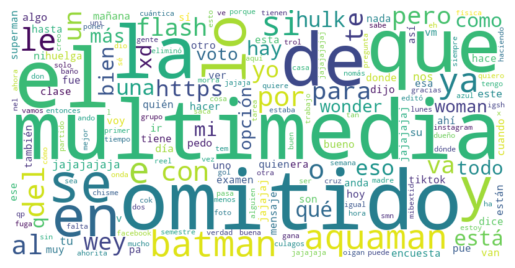

In [225]:
texto = " ".join(df["mensaje"].dropna())

wc = WordCloud(
    width=800, height=400,
    background_color="white",
    collocations=False
).generate(texto)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


La palabra `multimedia` y `omitido` se repite mucho. Notemos que **batman** se menciona mucho, pero es el integrante del grupo con menos actividad en el grupo. 

Ahora, quitemos las *stop-words* y las palabras que no reprecentan información: 

In [226]:
from wordcloud import STOPWORDS

**Nota**: No está funcionando el modelo `es_core_news_md`, por lo que se agregarán las stopwords más comunes a mano. 

In [227]:
# !uv pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.7.0/es_core_news_md-3.7.0-py3-none-any.whl

In [228]:
stopwords_spacy = set(STOPWORDS)

STOPWORDS_ES = {
    "de","la","que","el","en","y","a","los","se","del","las","por","un","para","con",
    "no","una","su","al","es","lo","como","más","mas","pero","sus","le","ya","o","fue","ha",
    "si","sí","cuando","muy","sin","sobre","también","tambien","me","hasta","hay","donde",
    "quien","quienes","desde","todo","todos","nos","durante","uno","les","ni","contra","otros",
    "cual","cuál","era","poco","ella","él","ellos","ellas","este","esta","estos","estas","esto",
    "aquí","aqui","alli","allí","mismo","cada","otro","otra","tan","tanto","tanta","qué","que",
    "porque","porqué","porq","q","k","xq","pq","tb","tmb","tqm","ok","vale","gracias","porfa",
    "porfis","pls","porfavor","jaja","jajaja","jeje","jejeje","xd","ajaja","mm","mmm","uh",
    "uhm","asi","aun","aún","todavia","todavía","entonces","aunque","mientras","hola","buenos",
    "buenas","buen","día","dia","tarde","noche","mi","mis","mio","mía","tu","tú","te","ti",
    "nosotros","vosotros","usted","ustedes","denada","de_nada","pues","lol","lmao","okey","pues", 
    "omitido", "multimedia", "yo", "https",  "batman", "wonder", "woman", "superman", "aquaman", "hulk", 
    "flash", "va", "esa", "ese", "puede", "oigan", "ser", "bueno", "gente", "hoy", "eso", "esta", 
    "opcion", "está", "dijo", "estoy", "opción", "quien", "dice", "son", "tienen", "ahi", "ahí", "así", 
    "dio", "ver", "ve", "vas", "nomás", "nomas", "quíen"
}

In [229]:
my_stopwords = stopwords_spacy | STOPWORDS_ES

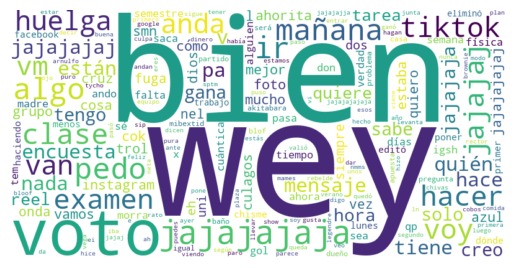

In [230]:
wc = WordCloud(
    width=800, height=400,
    background_color="white",
    stopwords=my_stopwords,
    collocations=False
).generate(texto)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


Vemos que la palabra más mencionada es "**wey**", lo que refleja el tono informal y cercano entre los particpantes. Otros términos que destacan son las relacionadas a **interacciones de risa** como *"jaja"* *"xd"*, así como referencias a redes sociales "tiktok" e "instagram", que probablemente generan las interacciones anteriores. Por otro lado, aparecen palabras asociadas a la **actividad académica** como *"tarea"*, *"examen"*, *"huelga"*, lo que confirma que gran parte de los mensajes están relacionados a temas escolares. 

### 4.5 ¿Quién escribe los mensajes más largos?

Contamos con las columnas `num_palabras`, `num_chars`. A partir de estas podemos analziar el comportameinto de los participantes del grupo.

Obtenemos la tabla para analizar estas variables: 

In [231]:
df.groupby('usuario')[['num_palabras', 'num_chars']].agg(['mean', 'std'])

num_palabras            num_chars           
                     mean       std       mean        std
usuario                                                  
<Sistema>        4.304348  4.958324  27.043478  31.652198
Aquaman          5.280316  9.251855  30.069420  50.293051
Batman           3.565603  4.157762  20.574468  34.414511
Flash            3.272231  2.460957  19.176214  16.997689
Hulk             4.165630  2.897969  22.470451  14.999724
Superman         4.624650  4.294936  28.492997  26.535704
Wonder Woman     4.128744  5.533364  22.910386  32.064676

Vemos un comportamiento interesante: 

El promedio de palabras por mensaje nos dice que tantas palabras necesita un usuario para expresarse. Entre más alto el promedio, más verboso es el miembro. Vemos que el promedio el integrante con el promedio más alto de palabras por mensaje es Aquaman, seguido por Superman y Wonder Woman. Por otro lado, Batman y Flash son los integrantes con menor cantidad de palabras por mensaje. 

La desviación estándar nos dice cuánta variación hay en el tamaño de los mensajes. Los valore altos indican que el usuario a veces manda mensajes muy cortos y a veces muy largos. Podemos agrupar a los usuarios según la variabilidad de longitud de sus mensajes: 

* Usuarios con más variabilidad en el tamaño de mensajes:

    * **Aquaman**: Muy alta variabilidad (9.25 palabras, 50.29 caracteres). Esto sugiere que a veces manda textos largos, otras veces muy cortos.

    * **Wonder Woman**: También tiene variabilidad alta, especialmente en caracteres (32.05).

* Usuarios  con menos variabilidad:

    * **Flash** y **Hulk**: Tienen los valores más bajos de desviación estándar, lo que sugiere un estilo de mensaje más constante y predecible.

    * Flash: 2.46 palabras, 16.99 caracteres.
    * Hulk: 2.89 palabras, 15.00 caracteres.

Batman es el usuario menos participativo, los mensajes son breves y balanceados (la desviación es baja comparados con los demás).

### 4.6 ¿Como cambia la actividad a lo largo del tiempo?

Para analizar la actividad temporal del grupo, agruparé por mes y verificaré si la epoca del año afecta la actividad. En particular me interesa responder: ¿las vacaciones influyen en la actividad del grupo?

Creamos la columna `year_month`: 

In [232]:
df['year_month_str'] = df['datetime'].dt.strftime('%Y-%m')

In [233]:
df['year_month_str'];  # OK

El total de mensajes por mes: 

In [234]:
mensajes_por_mes = df.groupby('year_month_str').size().reset_index(name='num_mensajes')
mensajes_por_mes.head()  # OK

,year_month_str,num_mensajes
0,2023-04,333
1,2023-05,1226
2,2023-06,1117
3,2023-07,528
4,2023-08,460


Ahora, graficamos los datos obtenidos: 

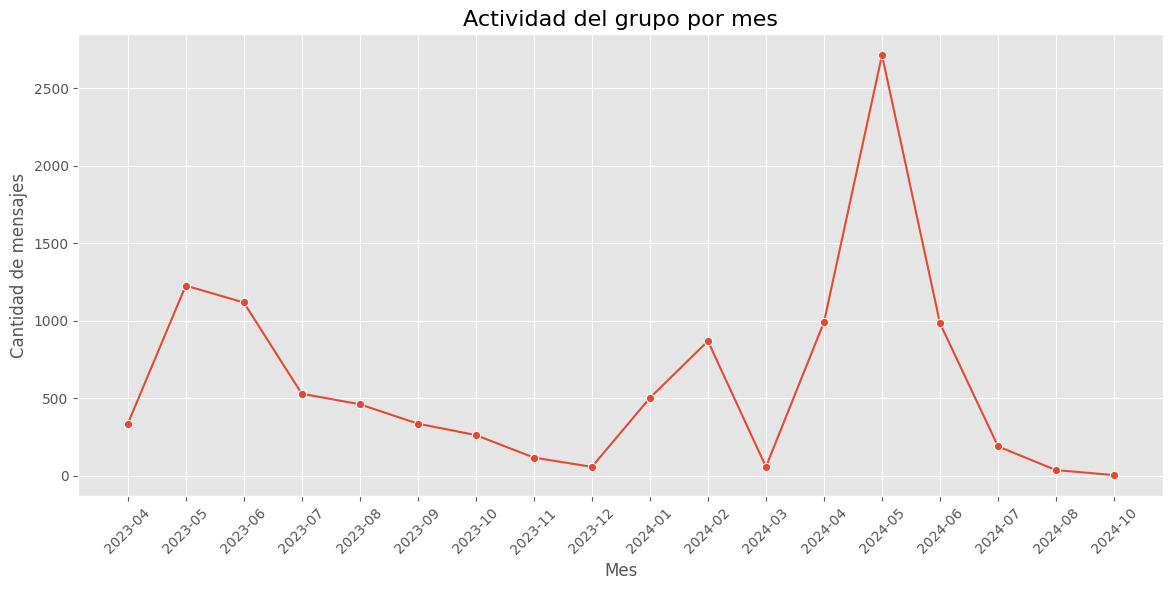

In [235]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=mensajes_por_mes,
    x='year_month_str',
    y='num_mensajes',
    marker='o',
)
plt.title('Actividad del grupo por mes', fontsize=16)
plt.xlabel('Mes')
plt.ylabel('Cantidad de mensajes')
plt.xticks(rotation=45)
plt.show()



Del análisis del *wordcloud* se sugiere que el grupo pertenece a un conjunto de personas con **actividades escolares en común**, ya que aparecen palabras relacionadas con la vida académica como *inscripción*, *grupo*, *tarea*, *examen*, así como palabras de interés común como *huelga* y *decisión*. 

El **comportamiento temporal del grupo** es irregular: la cantidad de mensajes no se mantiene constante a lo largo del tiempo, mostrando picos y valles según la época del año y los eventos relevantes.

Considerando el **periodo 2023**, los mensajes alcanzaron su **pico en abril** y se mantuvieron relativamente constantes hasta junio. Esta actividad coincide con el **cierre de semestre**, lo que probablemente influyó en la intensidad de la comunicación. Posteriormente, la cantidad de mensajes disminuyó gradualmente, llegando a casi **cero mensajes por mes en diciembre**, lo que puede relacionarse con las vacaciones.

En el **periodo 2024**, la actividad comenzó de manera intensa, coincidiendo con las **inscripciones escolares a los grupos**, que generaron un aumento en la interacción del grupo. En marzo se observó un **bajón en la actividad**, seguido de un repunte hasta mayo. Durante este año, la actividad académica se vio afectada por **huelgas y la incertidumbre sobre el regreso a clases**, lo que se refleja en la variabilidad de los mensajes.

En general, durante las **vacaciones no se registró una gran actividad**, mientras que los momentos de mayor interacción corresponden a **eventos relevantes del ámbito académico**, como inscripciones, toma de decisiones y conflictos universitarios. Esto indica que el grupo utiliza el grupo para coordinarse y mantenerse informado sobre asuntos académicos.

## 5 Conclusiones

Del análsis anterior, podemos sacar las siguientes conclusiones:

* El grupo muestra un **comportamiento muy desigual**: Wonder Woman domina la conversación con una alta participación, mientras que Batman es claramente el más reservado. 
 
* La actividad general sigue patrones relacionados con el calendario académico y eventos importantes, con picos de mensajes durante la mañana y los viernes.

* Los mensajes son en promedio breves, aunque algunos miembros como Aquaman y Wonder Woman presentan alta variabilidad en la longitud de sus mensajes, lo que indica que combinan textos cortos y largos.
Las palabras más frecuentes reflejan tanto la vida escolar (*tarea, examen, inscripción, huelga*) como interacciones informales (*wey, jaja, xd, tiktok, instagram*), confirmando que el grupo combina coordinación académica con socialización.

En conjunto, estos datos muestran un grupo activo y variado, con miembros muy participativos y otros más silenciosos, donde la comunicación se concentra en momentos clave del semestre escolar.